In [1]:
from sklearn import datasets

iris = datasets.load_iris()

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
import numpy as np
from sklearn.model_selection import GridSearchCV

In [3]:
import matplotlib.pyplot as plt

In [4]:
X = iris.data
#y = [1] * 50 + [0] * 100
y = [0] * 50 + [1] * 50 + [0] * 50

In [5]:
X_scaled = MaxAbsScaler().fit_transform(X)
X_reduced = PCA(n_components=2).fit_transform(X_scaled)
X_class, y_class = np.concatenate((X_reduced[:50], X_reduced[100:])), np.concatenate((y[:50], y[100:]))

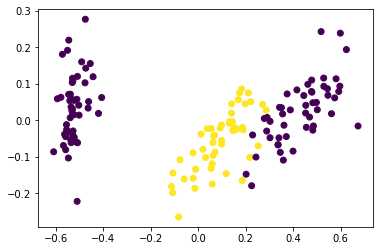

In [6]:
plt.scatter(X_reduced[:,0],X_reduced[:,1], c=y)
plt.show()

In [7]:
import sys

sys.path.append('..')

from flod.classifiers.bsvclassifier import BSVClassifier

In [8]:
max_dist = 0
for i in X:
    for j in X:
        dist = np.linalg.norm(i-j, ord=2)**2
        if dist > max_dist:
            max_dist = dist

print(f'Suggested q: {1/max_dist}')

Suggested q: 0.019920318725099598


In [9]:
q = 10
p = 50

c = 1

print(f'p={1 / (c*len(X_reduced))}')

p=0.006666666666666667


In [10]:
clf = BSVClassifier(n_iter=10, q=q, penalization=200)
clf.fit(X_class, y_class)

BSVClassifier(init_bound=0.1, n_iter=10, penalization=200, q=10, random_seed=42)

In [11]:
y_pred = clf.predict(X_reduced)

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f'Precision {precision_score(y, y_pred)}')
print(f'Recall {recall_score(y, y_pred)}')
print(f'F1 {f1_score(y, y_pred)}')
print(f'Accuracy {accuracy_score(y, y_pred)}')

Precision 1.0
Recall 0.46
F1 0.6301369863013699
Accuracy 0.82


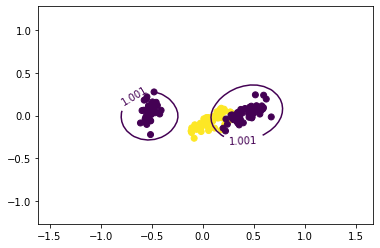

In [13]:
gx = np.linspace(min(X_reduced[:,0])-1, max(X_reduced[:,0])+1, 50)
gy = np.linspace(min(X_reduced[:,1])-1, max(X_reduced[:,1])+1, 50)
gX, gY = np.meshgrid(gx, gy)
zs = np.array([clf._compute_r(np.array([x, y])) for x, y in zip(np.ravel(gX), np.ravel(gY))])
gZ = zs.reshape(gX.shape)
membership_contour = plt.contour(gX, gY, gZ, levels=(clf.radiuses_[clf.sv_i], ))
plt.clabel(membership_contour, inline=1)

plt.scatter(X_reduced[:,0],X_reduced[:,1], c=y)
plt.show()

In [14]:
from joblib import dump, load
dump(clf, 'iris.joblib') 

['iris.joblib']

**Analizzare risultato di questa run in altro notebook**

Mi aspetto che esperimento qui sotto faccia schifo. C è uguale a 1 ma sto passando dei bsv.
Dovrei far si che training (aka solve optimization) lavori solo con dati con y = 0

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold


pipe = Pipeline([
        ('scaler', MaxAbsScaler()),
        ('reduce_dim', PCA()),
        ('classifier', BSVClassifier())
])

In [17]:
params = {
    #'scaler': [StandardScaler(), MaxAbsScaler(), RobustScaler(), QuantileTransformer()],
    'reduce_dim__n_components': range(iris.data.shape[1]),
    'classifier__n_iter': [10],
    'classifier__penalization': [10, 100, 200],
    'classifier__q': [1/max_dist, 1, 10, 100, 1000]
}

cv = StratifiedKFold(n_splits=3, shuffle=True)
search = GridSearchCV(pipe, params, n_jobs=-1, cv=cv, refit=True, verbose=5, return_train_score=True)

In [18]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 16.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler', MaxAbsScaler(copy=True)),
                                       ('reduce_dim',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('classifier',
                                        BSVClassifier(init_bound=0.1,
                                                      n_iter=100,
                                                      penalization=10, q=1,
                                                      random_seed=42))],
                                verbose=Fa

In [19]:
print(f'Best params: {search.best_params_}')
print(f'Best score: {search.best_score_}')

Best params: {'classifier__n_iter': 10, 'classifier__penalization': 100, 'classifier__q': 100, 'reduce_dim__n_components': 1}
Best score: 0.960190136660725


In [20]:
search.score(X_test, y_test)

0.96

In [21]:
search.cv_results_

{'mean_fit_time': array([26.81420167, 26.79873284, 26.86768794, 26.55250621, 26.4276042 ,
        24.9370416 , 24.9936254 , 24.94566552, 26.57801374, 23.43603555,
        23.60242478, 22.88908148, 26.51004632, 23.05505808, 22.07303754,
        21.77376684, 26.34842881, 22.2694006 , 21.09881377, 20.89806167,
        20.09247279, 20.08283997, 20.11805113, 20.10424717, 20.1774381 ,
        20.07036757, 19.6275696 , 19.54299617, 20.70585171, 19.66845886,
        19.83596198, 20.36171333, 19.93668254, 19.31565054, 19.7063671 ,
        20.1722428 , 19.84179282, 19.17330774, 19.50084448, 19.49809504,
        19.35408791, 19.73104421, 19.37032429, 19.72038031, 19.1486574 ,
        18.49220785, 18.78919951, 18.50634702, 19.34822941, 19.11445419,
        18.95131715, 19.0481716 , 19.25235558, 19.03978491, 18.88672853,
        18.89159091, 19.05221279, 19.12008429, 18.09023905, 13.9038918 ]),
 'std_fit_time': array([0.28929575, 0.55356014, 0.57812848, 0.03410401, 0.39773305,
        0.90936923, 0

In [22]:
clf = search.best_estimator_['classifier']

In [23]:
# TO CHECK PCA NUMBER OF COMPONENTS BEFORE PLOTTING
# gx = np.linspace(min(clf.X_[:,0])-1, max(clf.X_[:,0])+1, 50)
# gy = np.linspace(min(clf.X_[:,1])-1, max(clf.X_[:,1])+1, 50)
# gX, gY = np.meshgrid(gx, gy)
# zs = np.array([clf._compute_r(np.array([x, y])) for x, y in zip(np.ravel(gX), np.ravel(gY))])
# gZ = zs.reshape(gX.shape)
# membership_contour = plt.contour(gX, gY, gZ, levels=(clf.radiuses_[clf.sv_i], ))
# plt.clabel(membership_contour, inline=1)

# plt.scatter(clf.X_[:,0], clf.X_[:,1], c=clf.y_)
# plt.show()

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test, search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        33
           1       0.94      0.94      0.94        17

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



In [25]:
dump(clf, 'grid_iris.joblib') 

['grid_iris.joblib']